In [4]:
import os 
os.chdir('../../')


In [5]:
!ls logs/exp7

events.out.tfevents.1754753552.scpark-X299-WU8.153521.0  step_00000800.pt
events.out.tfevents.1754753901.scpark-X299-WU8.155769.0  step_00000900.pt
events.out.tfevents.1754754332.scpark-X299-WU8.158598.0  step_00001000.pt
events.out.tfevents.1754754499.scpark-X299-WU8.160018.0  step_00001100.pt
step_00000000.pt					 step_00001200.pt
step_00000100.pt					 step_00001300.pt
step_00000200.pt					 step_00001400.pt
step_00000300.pt					 step_00001500.pt
step_00000400.pt					 step_00001600.pt
step_00000500.pt					 step_00001700.pt
step_00000600.pt					 step_00001800.pt
step_00000700.pt


params shape: (5, 2, 5)


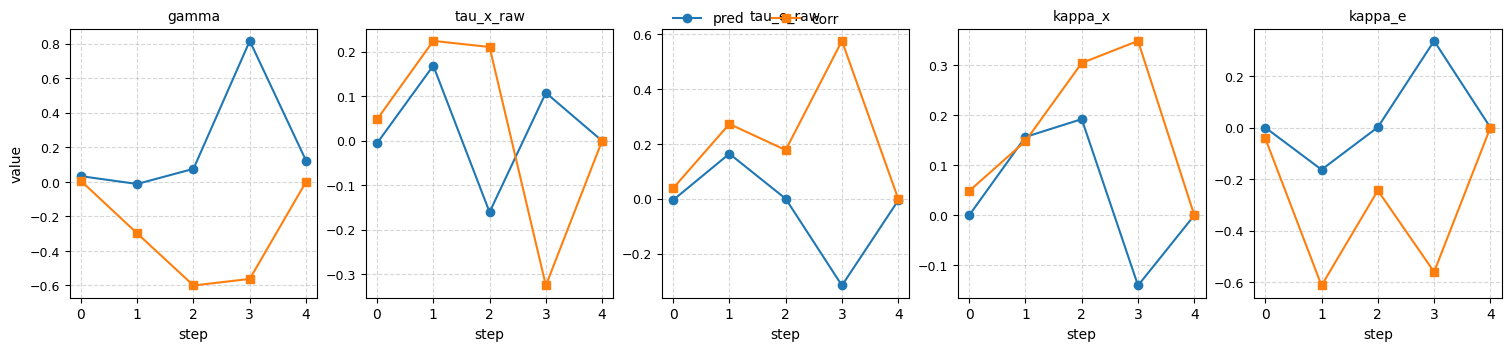

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ===== 설정 =====
ckpt_path = 'logs/exp7/step_00002200.pt'   # 경로 수정
state_dict_key = 'solver_state_dict'
param_key = 'params'
reduce_mode = 'mean'   # 'mean' 또는 'index0'
save_path = None       # 예: 'figs/params_row.png' (None이면 저장 안 함)

# 파라미터 순서 가정: [gamma, tau_x_raw, tau_e_raw, kappa_x, kappa_e]

def squeeze_params(p: torch.Tensor, mode: str = 'mean') -> torch.Tensor:
    """p: [S, 2, 5, ...] -> [S, 2, 5]로 축소"""
    if p.dim() <= 3:
        return p
    if mode == 'mean':
        extra = tuple(range(3, p.dim()))
        return p.mean(dim=extra)
    elif mode == 'index0':
        idx = (slice(None), slice(None), slice(None)) + (0,) * (p.dim() - 3)
        return p[idx]
    else:
        raise ValueError("reduce_mode must be 'mean' or 'index0'.")

def plot_params_row(params_np: np.ndarray, save_path: str | None = None):
    """
    params_np: [S, 2, 5]  (S=steps, 2=pred/corr, 5=params)
    tau는 raw 값만 그림.
    """
    assert params_np.ndim == 3 and params_np.shape[1] == 2 and params_np.shape[2] == 5, \
        f"Unexpected shape: {params_np.shape} (expected [S,2,5])"

    S = params_np.shape[0]
    steps = np.arange(S)

    pred = params_np[:, 0, :]  # [S,5]  (pred)
    corr = params_np[:, 1, :]  # [S,5]  (corr)

    cols = [
        ('gamma',     pred[:, 0], corr[:, 0]),
        ('tau_x_raw', pred[:, 1], corr[:, 1]),
        ('tau_e_raw', pred[:, 2], corr[:, 2]),
        ('kappa_x',   pred[:, 3], corr[:, 3]),
        ('kappa_e',   pred[:, 4], corr[:, 4]),
    ]

    fig_w = max(3.0 * len(cols), 6.0)
    fig, axes = plt.subplots(1, len(cols), figsize=(fig_w, 3.4), sharex=True, constrained_layout=True)
    if len(cols) == 1:
        axes = [axes]

    for j, (name, y_pred, y_corr) in enumerate(cols):
        ax = axes[j]
        ax.plot(steps, y_pred, marker='o', linewidth=1.5, label='pred')
        ax.plot(steps, y_corr, marker='s', linewidth=1.5, label='corr')
        ax.set_title(name, fontsize=10)
        ax.set_xlabel('step')

        # ✅ 모든 서브플롯에서 y축 tick 라벨 표시
        ax.tick_params(axis='y', which='both', labelleft=True, labelsize=9)
        if j == 0:
            ax.set_ylabel('value')

        ax.grid(True, linestyle='--', alpha=0.5)

    # 공통 범례
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=160)
        print(f"Saved: {save_path}")
    plt.show()

def main():
    weights = torch.load(ckpt_path, map_location='cpu')
    if state_dict_key not in weights:
        raise KeyError(f"'{state_dict_key}'가 체크포인트에 없습니다. keys={list(weights.keys())}")
    sd = weights[state_dict_key]
    if param_key not in sd:
        raise KeyError(f"'{param_key}'가 state_dict에 없습니다. keys={list(sd.keys())}")

    params = sd[param_key]                      # [S, 2, 5, ...] 가능
    params = squeeze_params(params, reduce_mode)  # -> [S, 2, 5]
    params_np = params.detach().cpu().float().numpy()
    print("params shape:", params_np.shape)     # 디버그용

    plot_params_row(params_np, save_path=save_path)

if __name__ == "__main__":
    main()
